In [1]:
import os
import wfdb
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# Define the path to your dataset directory
DATA_DIR = "C:/Users/M2-Winterfell/Downloads/electrocardiography-dataset-1.0.3/records500/00000"

# Function to load and extract Lead I and Lead II from a single record
def load_ecg_leads(file_path):
    try:
        # Load the record using wfdb (the file_path should be without extension)
        record = wfdb.rdrecord(file_path)
        
        # Extract Lead I and Lead II (assuming they are the first two leads)
        lead_I = record.p_signal[:, 0]  # Lead I
        lead_II = record.p_signal[:, 1]  # Lead II
        
        return lead_I, lead_II
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

# Function to load only the first 1000 ECG records
def load_first_n_ecg_data(data_dir, n=1000):
    all_lead_I = []
    all_lead_II = []
    
    count = 0  # To keep track of the number of records loaded
    
    # Traverse through all subdirectories in records500
    for root, dirs, files in os.walk(data_dir):
        for file in tqdm(files, desc="Loading ECG files"):
            if file.endswith("_hr.dat"):  # Look for files with the _hr suffix
                # Stop loading after reaching the first n records
                if count >= n:
                    break
                
                # Construct the base filename (removing the '_hr.dat' extension)
                base_filename = file.replace("_hr.dat", "_hr")
                record_path = os.path.join(root, base_filename)
                
                # Load Lead I and Lead II
                lead_I, lead_II = load_ecg_leads(record_path)
                
                if lead_I is not None and lead_II is not None:
                    all_lead_I.append(lead_I)
                    all_lead_II.append(lead_II)
                    count += 1
                else:
                    print(f"Skipping record: {base_filename}")

        if count >= n:  # Break the outer loop as well
            break
    
    # Convert lists to NumPy arrays if data was loaded
    if all_lead_I and all_lead_II:
        all_lead_I = np.array(all_lead_I)  # Shape: (num_records, samples_per_record)
        all_lead_II = np.array(all_lead_II)  # Shape: (num_records, samples_per_record)
    else:
        all_lead_I = np.array([])  # Empty array if no data
        all_lead_II = np.array([])  # Empty array if no data
    
    return all_lead_I, all_lead_II

# Load only the first 1000 ECG records from records500
lead_I_data, lead_II_data = load_first_n_ecg_data(DATA_DIR, n=1000)

# Check if data was loaded successfully
if lead_I_data.size > 0 and lead_II_data.size > 0:
    print(f"Total records loaded: {lead_I_data.shape[0]}")
    print(f"Each record has {lead_I_data.shape[1]} samples per lead.")
    
    # Check shapes
    print("Lead I data shape:", lead_I_data.shape)
    print("Lead II data shape:", lead_II_data.shape)
else:
    print("No data was loaded.")


Loading ECG files: 100%|██████████| 1974/1974 [00:03<00:00, 504.13it/s]

Total records loaded: 987
Each record has 5000 samples per lead.
Lead I data shape: (987, 5000)
Lead II data shape: (987, 5000)


In [2]:
# Initialize the scaler for normalization
scaler = MinMaxScaler(feature_range=(-1, 1))  # ECG signals can have negative values

# Normalize Lead I data
if lead_I_data.size > 0 and lead_II_data.size > 0:
    lead_I_scaled = scaler.fit_transform(lead_I_data)

    # Normalize Lead II data using the same scaler
    lead_II_scaled = scaler.transform(lead_II_data)

    # Verify normalization
    print("Lead I scaled data range:", lead_I_scaled.min(), lead_I_scaled.max())
    print("Lead II scaled data range:", lead_II_scaled.min(), lead_II_scaled.max())
else:
    print("Skipping normalization since no data was loaded.")

Lead I scaled data range: -1.0 1.0000000000000004
Lead II scaled data range: -3.4331450094161955 3.042488619119878


In [3]:
input_data = lead_I_scaled  
output_data = lead_II_scaled

print("Input data shape:", input_data.shape)
print("Output data shape:", output_data.shape)

Input data shape: (987, 5000)
Output data shape: (987, 5000)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Transpose1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=11, upsample=None, output_padding=1):
        super(Transpose1dLayer, self).__init__()
        self.upsample = upsample
        self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        reflection_pad = kernel_size // 2
        self.reflection_pad = nn.ConstantPad1d(reflection_pad, value=0)
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size, stride)
        self.Conv1dTrans = nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride, padding, output_padding)

    def forward(self, x):
        if self.upsample:
            return self.conv1d(self.reflection_pad(self.upsample_layer(x)))
        else:
            return self.Conv1dTrans(x)

class Transpose1dLayer_multi_input(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=11, upsample=None, output_padding=1):
        super(Transpose1dLayer_multi_input, self).__init__()
        self.upsample = upsample
        self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        reflection_pad = kernel_size // 2
        self.reflection_pad = nn.ConstantPad1d(reflection_pad, value=0)
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size, stride)
        self.Conv1dTrans = nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride, padding, output_padding)

    def forward(self, x, in_feature):
        if self.upsample:
            x = torch.cat((x, in_feature), 1)
            return self.conv1d(self.reflection_pad(self.upsample_layer(x)))
        else:
            return self.Conv1dTrans(x)

class Pulse2PulseGenerator(nn.Module):
    def __init__(self, model_size=50, num_leads=1, post_proc_filt_len=512, verbose=False, upsample=True):
        super(Pulse2PulseGenerator, self).__init__()
        self.model_size = model_size
        self.num_leads = num_leads
        self.post_proc_filt_len = post_proc_filt_len
        self.verbose = verbose
        
        stride = 4
        if upsample:
            stride = 1
            upsample = 5
        
        # Update transpose layers for single input/output channel
        self.deconv_1 = Transpose1dLayer(5 * model_size, 5 * model_size, 25, stride, upsample=upsample)
        self.deconv_2 = Transpose1dLayer_multi_input(5 * model_size * 2, 3 * model_size, 25, stride, upsample=upsample)
        self.deconv_3 = Transpose1dLayer_multi_input(3 * model_size * 2, model_size, 25, stride, upsample=upsample)
        self.deconv_5 = Transpose1dLayer_multi_input(model_size * 2, int(model_size / 2), 25, stride, upsample=2)
        self.deconv_6 = Transpose1dLayer_multi_input(int(model_size / 2) * 2, int(model_size / 5), 25, stride, upsample=upsample)
        self.deconv_7 = Transpose1dLayer(int(model_size / 5), 1, 25, stride, upsample=2)  # Final output has 1 channel for Lead II

        # Convolutional layers for single-channel input
        self.conv_1 = nn.Conv1d(num_leads, int(model_size / 5), 25, stride=2, padding=25 // 2)
        self.conv_2 = nn.Conv1d(model_size // 5, model_size // 2, 25, stride=5, padding=25 // 2)
        self.conv_3 = nn.Conv1d(model_size // 2, model_size, 25, stride=2, padding=25 // 2)
        self.conv_4 = nn.Conv1d(model_size, model_size * 3, 25, stride=5, padding=25 // 2)
        self.conv_5 = nn.Conv1d(model_size * 3, model_size * 5, 25, stride=5, padding=25 // 2)
        self.conv_6 = nn.Conv1d(model_size * 5, model_size * 5, 25, stride=5, padding=25 // 2)

        if post_proc_filt_len:
            self.ppfilter1 = nn.Conv1d(1, 1, post_proc_filt_len)  # Single output channel post-processing filter

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)

    def forward(self, x):
        conv_1_out = F.leaky_relu(self.conv_1(x))
        conv_2_out = F.leaky_relu(self.conv_2(conv_1_out))
        conv_3_out = F.leaky_relu(self.conv_3(conv_2_out))
        conv_4_out = F.leaky_relu(self.conv_4(conv_3_out))
        conv_5_out = F.leaky_relu(self.conv_5(conv_4_out))
        x = F.leaky_relu(self.conv_6(conv_5_out))

        # Deconvolution layers with skip connections
        x = F.relu(self.deconv_1(x))
        x = F.relu(self.deconv_2(x, conv_5_out))
        x = F.relu(self.deconv_3(x, conv_4_out))
        x = F.relu(self.deconv_5(x, conv_3_out))
        x = F.relu(self.deconv_6(x, conv_2_out))

        output = torch.tanh(self.deconv_7(x))
        if self.verbose:
            print(output.shape)
        return output

# Phase Shuffle Layer
class PhaseShuffle(nn.Module):
    def __init__(self, shift_factor):
        super(PhaseShuffle, self).__init__()
        self.shift_factor = shift_factor

    def forward(self, x):
        if self.shift_factor == 0:
            return x
        k_list = torch.randint(-self.shift_factor, self.shift_factor + 1, (x.shape[0],), device=x.device)
        x_shuffle = x.clone()
        for idx, k in enumerate(k_list):
            if k > 0:
                x_shuffle[idx] = F.pad(x[idx][..., :-k], (k, 0), mode='reflect')
            elif k < 0:
                x_shuffle[idx] = F.pad(x[idx][..., -k:], (0, -k), mode='reflect')
        return x_shuffle


# Updated Discriminator with Phase Shuffle
class Pulse2PulseDiscriminator(nn.Module):
    def __init__(self, model_size=64, shift_factor=2, alpha=0.2):
        super(Pulse2PulseDiscriminator, self).__init__()
        self.alpha = alpha

        # Define convolutional layers
        self.conv1 = nn.Conv1d(1, model_size, kernel_size=25, stride=2, padding=12)
        self.conv2 = nn.Conv1d(model_size, 2 * model_size, kernel_size=25, stride=2, padding=12)
        self.conv3 = nn.Conv1d(2 * model_size, 5 * model_size, kernel_size=25, stride=2, padding=12)
        self.conv4 = nn.Conv1d(5 * model_size, 10 * model_size, kernel_size=25, stride=2, padding=12)
        self.conv5 = nn.Conv1d(10 * model_size, 20 * model_size, kernel_size=25, stride=2, padding=12)

        # Phase Shuffle Layers
        self.ps1 = PhaseShuffle(shift_factor)
        self.ps2 = PhaseShuffle(shift_factor)
        self.ps3 = PhaseShuffle(shift_factor)
        self.ps4 = PhaseShuffle(shift_factor)
        self.ps5 = PhaseShuffle(shift_factor)

        # Fully connected layer
        self.fc1 = nn.Linear(20 * model_size * 157, 1)  # Adjusted to match flattened feature map size

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=self.alpha)
        x = self.ps1(x)
        x = F.leaky_relu(self.conv2(x), negative_slope=self.alpha)
        x = self.ps2(x)
        x = F.leaky_relu(self.conv3(x), negative_slope=self.alpha)
        x = self.ps3(x)
        x = F.leaky_relu(self.conv4(x), negative_slope=self.alpha)
        x = self.ps4(x)
        x = F.leaky_relu(self.conv5(x), negative_slope=self.alpha)
        x = self.ps5(x)

        # Flatten and pass through the fully connected layer
        x = x.view(x.size(0), -1)
        return torch.sigmoid(self.fc1(x))

Epoch [1/10], Generator Loss: 1.7131586074829102, Discriminator Loss: 1.0073078870773315
Epoch [2/10], Generator Loss: 0.7289443612098694, Discriminator Loss: 1.3205769062042236


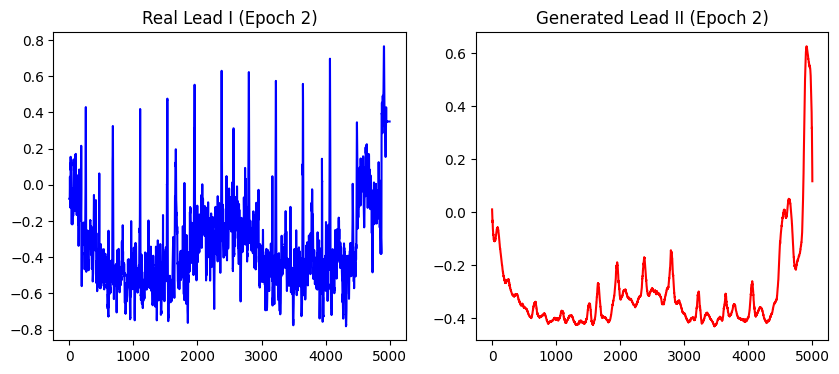

Epoch [3/10], Generator Loss: 0.7411420345306396, Discriminator Loss: 1.348669171333313
Epoch [4/10], Generator Loss: 0.8156460523605347, Discriminator Loss: 1.2713873386383057


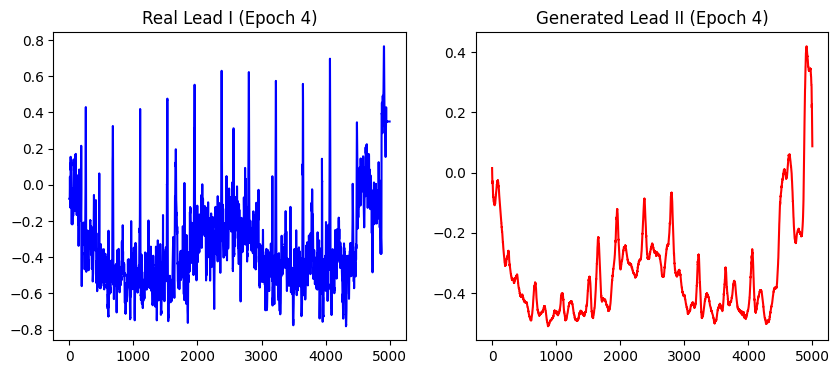

Epoch [5/10], Generator Loss: 0.7525748014450073, Discriminator Loss: 1.3713860511779785
Epoch [6/10], Generator Loss: 0.7578030824661255, Discriminator Loss: 1.3166773319244385


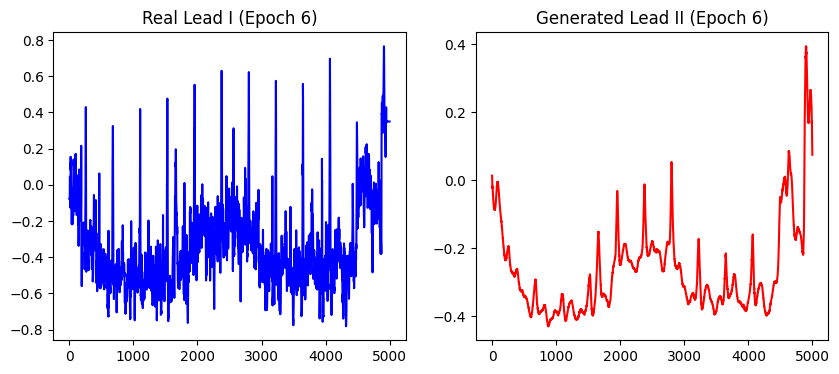

Epoch [7/10], Generator Loss: 0.7746671438217163, Discriminator Loss: 2.7680723667144775
Epoch [8/10], Generator Loss: 1.053229808807373, Discriminator Loss: 1.0839059352874756


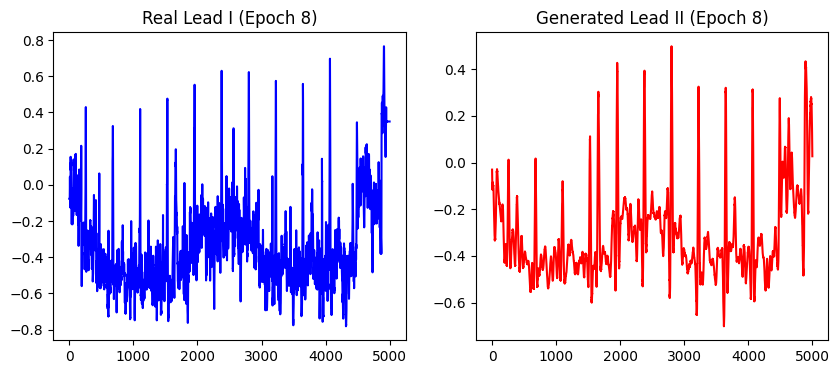

Epoch [9/10], Generator Loss: 1.1521486043930054, Discriminator Loss: 1.378072738647461
Epoch [10/10], Generator Loss: 20.02617835998535, Discriminator Loss: 100.0


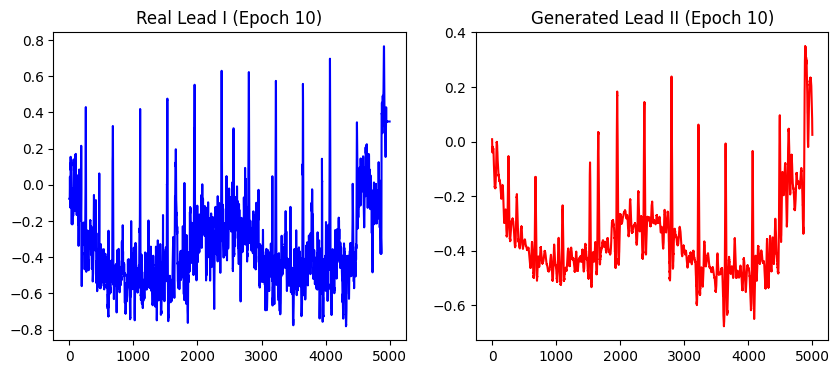

Pulse2PulseGenerator(
  (deconv_1): Transpose1dLayer(
    (upsample_layer): Upsample(scale_factor=5.0, mode='nearest')
    (reflection_pad): ConstantPad1d(padding=(12, 12), value=0)
    (conv1d): Conv1d(250, 250, kernel_size=(25,), stride=(1,))
    (Conv1dTrans): ConvTranspose1d(250, 250, kernel_size=(25,), stride=(1,), padding=(11,), output_padding=(1,))
  )
  (deconv_2): Transpose1dLayer_multi_input(
    (upsample_layer): Upsample(scale_factor=5.0, mode='nearest')
    (reflection_pad): ConstantPad1d(padding=(12, 12), value=0)
    (conv1d): Conv1d(500, 150, kernel_size=(25,), stride=(1,))
    (Conv1dTrans): ConvTranspose1d(500, 150, kernel_size=(25,), stride=(1,), padding=(11,), output_padding=(1,))
  )
  (deconv_3): Transpose1dLayer_multi_input(
    (upsample_layer): Upsample(scale_factor=5.0, mode='nearest')
    (reflection_pad): ConstantPad1d(padding=(12, 12), value=0)
    (conv1d): Conv1d(300, 50, kernel_size=(25,), stride=(1,))
    (Conv1dTrans): ConvTranspose1d(300, 50, kernel_s

In [ ]:
# Import necessary modules
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Initialize models
generator = Pulse2PulseGenerator()
discriminator = Pulse2PulseDiscriminator()

# Move the models to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)

# Optimizers for both generator and discriminator
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function for adversarial training
adversarial_loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss for real/fake classification

# Loss function for reconstruction (generator's MSE to target real Lead II)
reconstruction_loss_fn = nn.MSELoss()

# Ensure the data is correctly shaped: [batch_size, channels, sequence_length]
input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(1).to(device)  # Shape: (987, 1, 5000) for Lead I
output_data = torch.tensor(output_data, dtype=torch.float32).unsqueeze(1).to(device)  # Shape: (987, 1, 5000) for Lead II

# Training parameters
epochs = 10
batch_size = 32  # Adjust batch size based on memory constraints
real_label = 0.8  # Soft label for real data
fake_label = 0.2  # Soft label for fake data

# Training loop
for epoch in range(epochs):
    generator.train()
    discriminator.train()

    for i in range(0, len(input_data), batch_size):
        
        # Get batch data
        input_lead_I = input_data[i:i + batch_size]
        real_lead_II = output_data[i:i + batch_size]

        # Train Discriminator
        d_optimizer.zero_grad()
        real_preds = discriminator(real_lead_II)
        real_targets = torch.full_like(real_preds, real_label, device=device)
        real_loss = adversarial_loss_fn(real_preds, real_targets)

        generated_lead_II = generator(input_lead_I)
        fake_preds = discriminator(generated_lead_II.detach())
        fake_targets = torch.full_like(fake_preds, fake_label, device=device)
        fake_loss = adversarial_loss_fn(fake_preds, fake_targets)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        generated_lead_II = generator(input_lead_I)
        fake_preds = discriminator(generated_lead_II)
        g_adv_loss = adversarial_loss_fn(fake_preds, real_targets)
        g_recon_loss = reconstruction_loss_fn(generated_lead_II, real_lead_II)
        g_loss = g_adv_loss + g_recon_loss
        g_loss.backward()
        g_optimizer.step()

    print(f'Epoch [{epoch + 1}/{epochs}], Generator Loss: {g_loss.item()}, Discriminator Loss: {d_loss.item()}')

    # Visualization every 5 epochs
    if (epoch + 1) % 2 == 0:
        generator.eval()
        with torch.no_grad():
            generated_sample = generator(input_lead_I[:1])  # Take a single sample from batch for visualization

        # Plotting the real Lead I and generated Lead II
        plt.figure(figsize=(10, 4))
        
        # Plot real Lead I input
        plt.subplot(1, 2, 1)
        plt.plot(input_lead_I[0][0].cpu().numpy(), color='blue')
        plt.title(f'Real Lead I (Epoch {epoch + 1})')
        
        # Plot generated Lead II output
        plt.subplot(1, 2, 2)
        plt.plot(generated_sample[0][0].cpu().numpy(), color='red')
        plt.title(f'Generated Lead II (Epoch {epoch + 1})')
        
        # Save plot
        # plt.savefig(f'gan_training_epoch_{epoch + 1}.png')
        plt.show()

# Switch the generator to evaluation mode after training
generator.eval()
